In [1]:
import os
import h5py
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from prettytable import PrettyTable
from torchvision import transforms
from ptflops import get_model_complexity_info
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# Dataset class for DIV2K
class DIV2KDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        # Load image file paths, filtering for valid image extensions
        self.image_files = [
            os.path.join(root_dir, 'images', split, f)
            for f in os.listdir(os.path.join(root_dir, 'images', split))
            if f.endswith(('.png', '.jpg', '.jpeg'))  # Ensure valid image extensions
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        try:
            image = Image.open(img_name).convert('RGB')  # Convert to RGB
        except (UnidentifiedImageError, OSError) as e:
            print(f"Error loading image {img_name}: {e}")
            return None  # Handle the error gracefully

        if self.transform:
            image = self.transform(image)

        return image

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))  # Set to a higher resolution
])

root_dir = "DATASET/DIV2K/data"
train_dataset = DIV2KDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = DIV2KDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = DIV2KDataset(root_dir=root_dir, split='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) #  load data in batches 
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [4]:
# Depthwise Separable Convolution Definition
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = DepthwiseSeparableConv(in_channels, in_channels)
        self.conv2 = DepthwiseSeparableConv(in_channels, in_channels)

    def forward(self, x):
        identity = x  # Save the input for the skip connection
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity  # Add the input (skip connection)
        out = F.relu(out)  # Apply ReLU after adding
        return out

# Transformer Block Definition
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(),
            nn.Linear(embed_size * 4, embed_size),
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, seq_length, embed_size)
        attention_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout1(attention_output))  # Residual connection
        forward_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(forward_output))  # Residual connection
        return x

# SWSR Model Definition with Residual Block and Transformer Block
class SWSR(nn.Module):
    def __init__(self):
        super(SWSR, self).__init__()

        # Convolutional layers before transformer block
        self.conv1 = DepthwiseSeparableConv(3, 64)

        # Residual Block
        self.residual_block = ResidualBlock(64)

        # Transformer Block (requires reshaping input to [batch_size * seq_length] format)
        self.transformer_block = TransformerBlock(embed_size=64, heads=8)  # Use correct embedding size

        # Convolutional layers after transformer block
        self.conv2 = DepthwiseSeparableConv(64, 32)

        # Deconvolution layer and final convolution layer
        self.deconv = nn.ConvTranspose2d(32, 3, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(3, 3, kernel_size=5, padding=2)

    def forward(self, x):
        # Initial convolution and residual block processing
        x = F.relu(self.conv1(x))
        x = self.residual_block(x)

        # Reshape for transformer block (preserving channel dimension)
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).flatten(1, 2)  # Reshape to (batch_size, h*w, c)
        x = self.transformer_block(x)

        # Reshape back to original dimensions for further processing
        x = x.view(b, h, w, c).permute(0, 3, 1, 2)

        # Further convolutional processing and output generation
        x = F.relu(self.conv2(x))
        x = self.deconv(x)
        x = self.conv3(x)

        return x

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SWSR().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary and number of parameters
print("Model Summary:")
summary(model, input_size=(3, 64, 64))

# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

# Calculate MACs (Multiply-Accumulate operations)
macs, params = get_model_complexity_info(model, (3, 64, 64), as_strings=True, print_per_layer_stat=True)
print(f'Computational complexity (MACs): {macs}')
print(f'Number of parameters: {params}')

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 64, 64]              30
            Conv2d-2           [-1, 64, 64, 64]             256
DepthwiseSeparableConv-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]             640
            Conv2d-5           [-1, 64, 64, 64]           4,160
DepthwiseSeparableConv-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]             640
            Conv2d-8           [-1, 64, 64, 64]           4,160
DepthwiseSeparableConv-9           [-1, 64, 64, 64]               0
    ResidualBlock-10           [-1, 64, 64, 64]               0
MultiheadAttention-11  [[-1, 4096, 64], [-1, 2, 2]]               0
          Dropout-12             [-1, 4096, 64]               0
        LayerNorm-13             [-1, 4096, 64]             128
        

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
def calculate_metrics(output, target):
    output_np = output.permute(0, 2, 3, 1).cpu().numpy() #  Changes the order of dimensions of the tensor. If the original shape is (batch_size, channels, height, width), it changes it to (batch_size, height, width, channels).
    target_np = target.permute(0, 2, 3, 1).cpu().numpy()
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5) for o, t in zip(output_np, target_np)])
    psnr_val = np.mean([psnr(t, o, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    return ssim_val, psnr_val, mse_val

Epoch [1/20], Step [1/27], Loss: 0.0000
Epoch [1/20], Step [2/27], Loss: 0.0000
Epoch [1/20], Step [3/27], Loss: 0.0000
Epoch [1/20], Step [4/27], Loss: 0.0000
Epoch [1/20], Step [5/27], Loss: 0.0000
Epoch [1/20], Step [6/27], Loss: 0.0000
Epoch [1/20], Step [7/27], Loss: 0.0001
Epoch [1/20], Step [8/27], Loss: 0.0000
Epoch [1/20], Step [9/27], Loss: 0.0000
Epoch [1/20], Step [10/27], Loss: 0.0000
Epoch [1/20], Step [11/27], Loss: 0.0000
Epoch [1/20], Step [12/27], Loss: 0.0000
Epoch [1/20], Step [13/27], Loss: 0.0000
Epoch [1/20], Step [14/27], Loss: 0.0000
Epoch [1/20], Step [15/27], Loss: 0.0000
Epoch [1/20], Step [16/27], Loss: 0.0000
Epoch [1/20], Step [17/27], Loss: 0.0000
Epoch [1/20], Step [18/27], Loss: 0.0000
Epoch [1/20], Step [19/27], Loss: 0.0000
Epoch [1/20], Step [20/27], Loss: 0.0000
Epoch [1/20], Step [21/27], Loss: 0.0000
Epoch [1/20], Step [22/27], Loss: 0.0000
Epoch [1/20], Step [23/27], Loss: 0.0000
Epoch [1/20], Step [24/27], Loss: 0.0000
Epoch [1/20], Step [25/27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


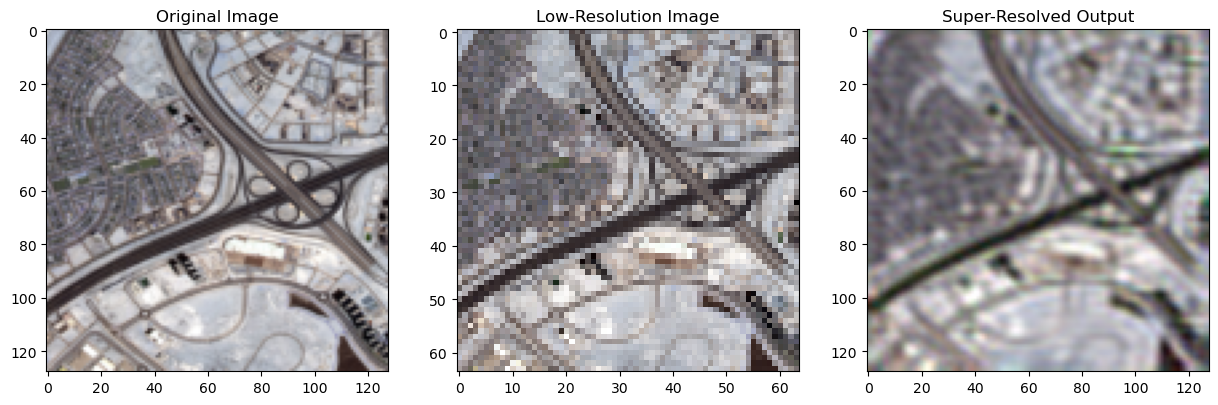

Epoch [11/20], Step [1/27], Loss: 0.0001
Epoch [11/20], Step [2/27], Loss: 0.0002
Epoch [11/20], Step [3/27], Loss: 0.0003
Epoch [11/20], Step [4/27], Loss: 0.0002
Epoch [11/20], Step [5/27], Loss: 0.0002
Epoch [11/20], Step [6/27], Loss: 0.0002
Epoch [11/20], Step [7/27], Loss: 0.0001
Epoch [11/20], Step [8/27], Loss: 0.0001
Epoch [11/20], Step [9/27], Loss: 0.0002
Epoch [11/20], Step [10/27], Loss: 0.0001
Epoch [11/20], Step [11/27], Loss: 0.0001
Epoch [11/20], Step [12/27], Loss: 0.0001
Epoch [11/20], Step [13/27], Loss: 0.0001
Epoch [11/20], Step [14/27], Loss: 0.0001
Epoch [11/20], Step [15/27], Loss: 0.0000
Epoch [11/20], Step [16/27], Loss: 0.0001
Epoch [11/20], Step [17/27], Loss: 0.0001
Epoch [11/20], Step [18/27], Loss: 0.0001
Epoch [11/20], Step [19/27], Loss: 0.0000
Epoch [11/20], Step [20/27], Loss: 0.0001
Epoch [11/20], Step [21/27], Loss: 0.0001
Epoch [11/20], Step [22/27], Loss: 0.0001
Epoch [11/20], Step [23/27], Loss: 0.0000
Epoch [11/20], Step [24/27], Loss: 0.0001
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


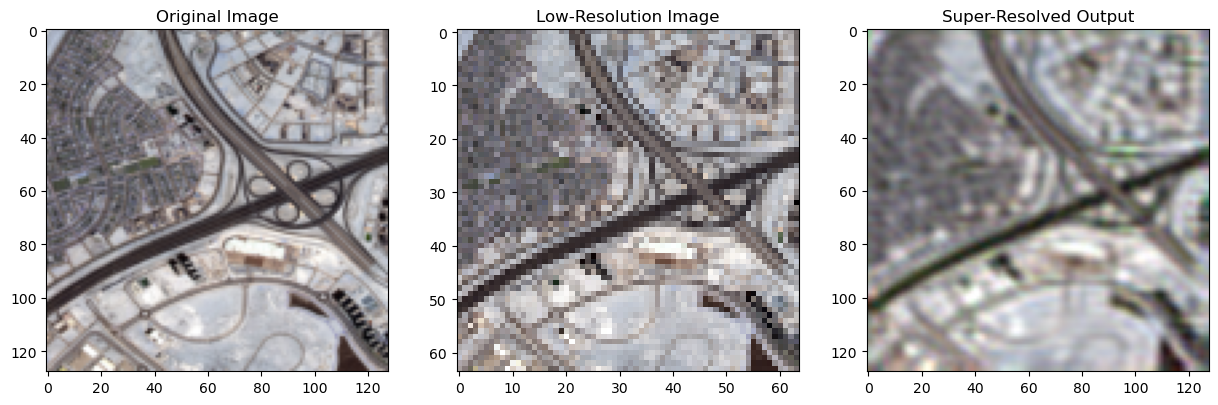

Training metrics saved to 'training_metrics.xlsx'.


In [9]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_psnr = float('-inf')  # Initialize best PSNR to negative infinity

def visualize_progress(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs = data.to(device)
            inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
            outputs = model(inputs_low_res)
            outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

            # Display the input, low-res, and output images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
            axs[0].set_title('Original Image')
            axs[1].imshow(inputs_low_res[0].cpu().permute(1, 2, 0))
            axs[1].set_title('Low-Resolution Image')
            axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
            axs[2].set_title('Super-Resolved Output')
            plt.show()

            # Only visualize one batch for simplicity
            break

# Lists to store metrics for each epoch
losses = []
psnrs = []
ssims = []  # List to store SSIM values
mses = []   # List to store MSE values

for epoch in range(num_epochs):
    model.train()
    total_loss = 0  # Initialize total loss for the epoch
    for i, data in enumerate(train_loader):
        inputs = data.to(device)
        inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
        outputs = model(inputs_upsampled)
        loss = criterion(outputs, inputs_upsampled)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate loss

        if (i + 1) % 1 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  # Store average loss

    # Validation
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data.to(device)
            inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
            outputs = model(inputs_upsampled)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs_upsampled)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    avg_ssim = ssim_total / len(val_loader)
    avg_psnr = psnr_total / len(val_loader)
    avg_mse = mse_total / len(val_loader)

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}, MSE: {avg_mse:.4f}')

    psnrs.append(avg_psnr)  # Store average PSNR
    ssims.append(avg_ssim)   # Store average SSIM
    mses.append(avg_mse)     # Store average MSE

    # Save the best model based on PSNR
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        print(f'Saving the best model with PSNR: {best_psnr:.4f}')
        
        # Save the model state dictionary to a .h5 file
        with h5py.File('best_model.pth', 'w') as f:
            for key, value in model.state_dict().items():
                f.create_dataset(key, data=value.cpu().numpy())  # Convert tensor to numpy array

    # Visualize progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_progress(model, val_loader)  # Use validation loader for visualization

# Create a DataFrame from the collected metrics
metrics_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Loss': losses,
    'PSNR': psnrs,
    'SSIM': ssims,
    'MSE': mses   # Include MSE in the DataFrame
})

# Save the DataFrame to an Excel file
metrics_df.to_excel('training_metrics.xlsx', index=False)

print("Training metrics saved to 'training_metrics.xlsx'.")


   Epoch      Loss       PSNR      SSIM       MSE
0      1  0.000033  45.514506  0.995592  0.000034
1      2  0.000029  45.406827  0.995271  0.000034
2      3  0.000028  44.829886  0.995612  0.000038
3      4  0.000030  44.965358  0.994920  0.000037
4      5  0.000029  43.402643  0.995306  0.000050
Index(['Epoch', 'Loss', 'PSNR', 'SSIM', 'MSE'], dtype='object')


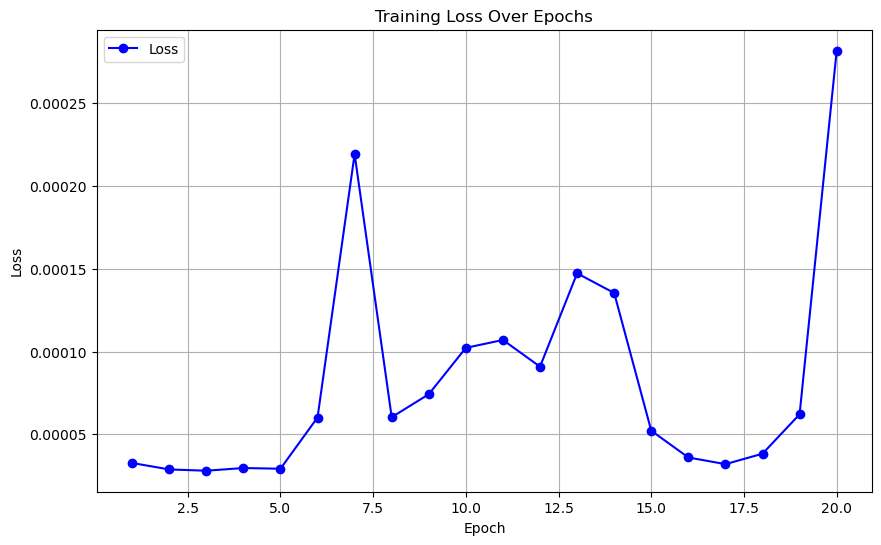

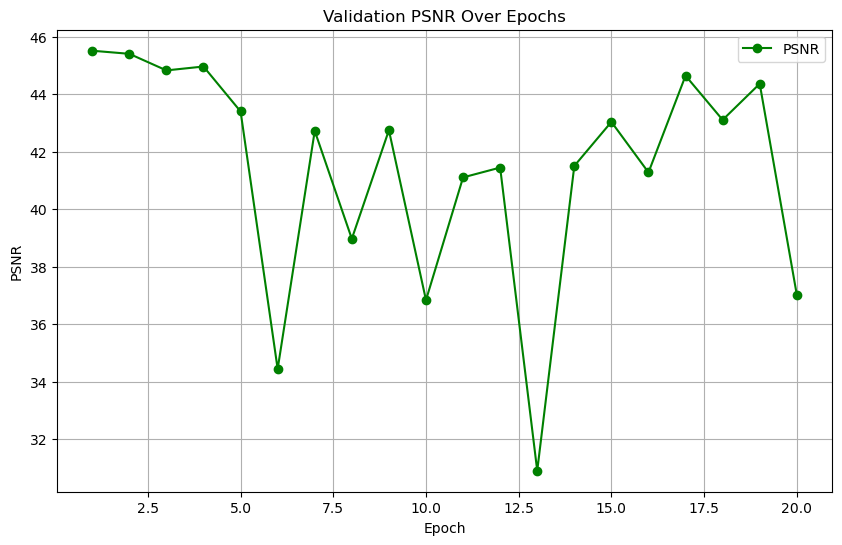

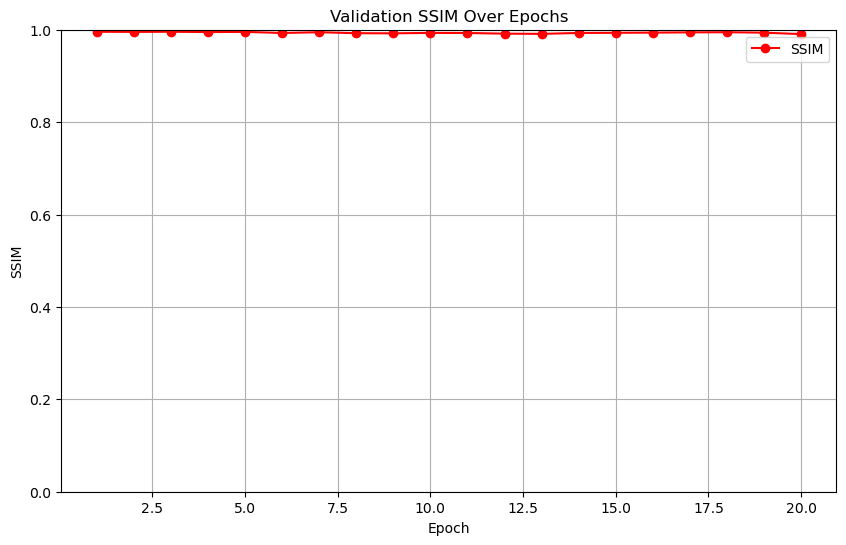

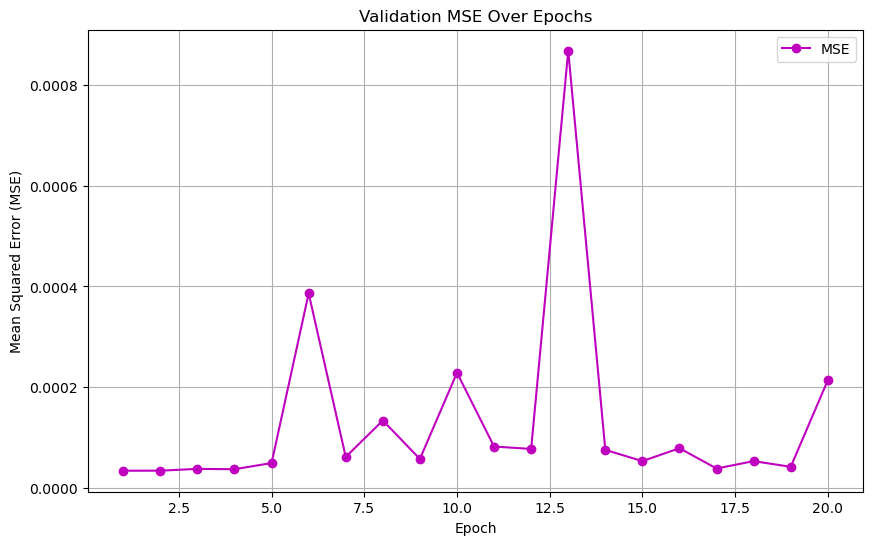

In [11]:
# Step 1: Load the dataset from an Excel file
file_path = 'training_metrics.xlsx'  # Replace with your actual file path
data = pd.read_excel(file_path)

# Step 2: Check the first few rows of the dataframe and print column names
print(data.head())
print(data.columns)  # Print column names to verify

# Step 3: Extract x and y values using actual column names
x = data['Epoch']  # Use 'Epoch' for x-axis
y_loss = data['Loss']  # Use 'Loss' for y-axis
y_psnr = data['PSNR']  # Use 'PSNR' for y-axis
y_ssim = data['SSIM']  # Use 'SSIM' for y-axis
y_mse = data['MSE']    # Use 'MSE' for y-axis

# Step 4: Create a plot for Loss
plt.figure(figsize=(10, 6))
plt.plot(x, y_loss, marker='o', linestyle='-', color='b', label='Loss')  # Plot Loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.savefig('loss_plot.png')  # Save Loss plot as PNG
plt.show()  # Display Loss plot

# Step 5: Create a plot for PSNR
plt.figure(figsize=(10, 6))
plt.plot(x, y_psnr, marker='o', linestyle='-', color='g', label='PSNR')  # Plot PSNR
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('Validation PSNR Over Epochs')
plt.grid(True)
plt.legend()
plt.savefig('psnr_plot.png')  # Save PSNR plot as PNG
plt.show()  # Display PSNR plot

# Step 6: Create a plot for SSIM with y-axis limits between 0 and 1
plt.figure(figsize=(10, 6))
plt.plot(x, y_ssim, marker='o', linestyle='-', color='r', label='SSIM')  # Plot SSIM
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM Over Epochs')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits to range between 0 and 1
plt.savefig('ssim_plot.png')  # Save SSIM plot as PNG
plt.show()  # Display SSIM plot

# Step 7: Create a plot for MSE
plt.figure(figsize=(10, 6))
plt.plot(x, y_mse, marker='o', linestyle='-', color='m', label='MSE')  # Plot MSE
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Validation MSE Over Epochs')
plt.grid(True)
plt.legend()
plt.savefig('mse_plot.png')  # Save MSE plot as PNG
plt.show()  # Display MSE plot


In [12]:
# Assuming SWSR class is defined as in your previous code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SWSR().to(device)

# Load the best model weights from .h5 file
with h5py.File('best_model.pth', 'r') as f:
    state_dict = {key: torch.from_numpy(f[key][()]) for key in f.keys()}  # Load each dataset as a tensor

model.load_state_dict(state_dict)  # Load weights into your model

# Define your evaluate function
def evaluate(model, dataloader):
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data.to(device)
            inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
            outputs = model(inputs_upsampled)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs_upsampled)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    print(f'Test - SSIM: {ssim_total/len(dataloader):.4f}, PSNR: {psnr_total/len(dataloader):.4f}, MSE: {mse_total/len(dataloader):.4f}')

# Assuming test_loader is defined and contains your test dataset
evaluate(model, test_loader)


Test - SSIM: 0.9956, PSNR: 45.5145, MSE: 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


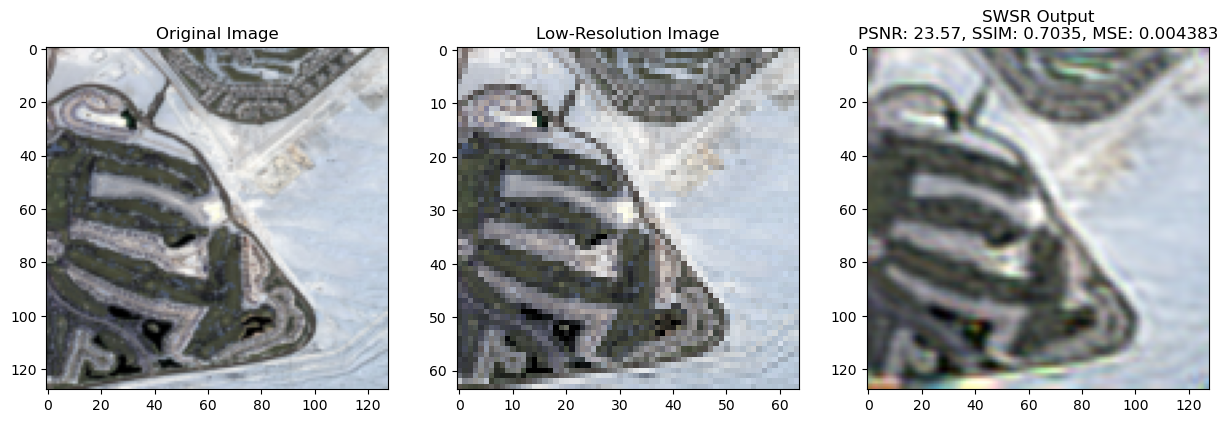

Test - SSIM: 0.9951, PSNR: 45.3887, MSE: 0.0000


In [20]:
# Load the best model weights from .h5 file
def load_model_from_h5(model, file_path):
    with h5py.File(file_path, 'r') as f:
        state_dict = {key: torch.from_numpy(f[key][()]) for key in f.keys()}  # Load each dataset as a tensor
    model.load_state_dict(state_dict)  # Load weights into your model

# Function to visualize one random image from the dataloader
def visualize_one_random_image(model, dataloader):
    model.eval()
    with torch.no_grad():
        data_iter = iter(dataloader)
        data = next(data_iter)
        inputs = data[0].to(device)  # Assuming data is a tuple (input_images, labels)

        # Ensure inputs are 4D (batch_size, channels, height, width)
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(0)  # Add batch dimension if necessary

        inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
        outputs = model(inputs_low_res)
        outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

        # Calculate metrics
        ssim_val, psnr_val, mse_val = calculate_metrics(outputs_upsampled, inputs)

        # Display the input, low-res, and output images
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
        axs[0].set_title('Original Image')
        axs[1].imshow(inputs_low_res[0].cpu().permute(1, 2, 0))
        axs[1].set_title('Low-Resolution Image')
        axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
        axs[2].set_title(f'SWSR Output\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}, MSE: {mse_val:.6f}')
        plt.show()

# Define your evaluate function
def evaluate(model, dataloader):
    model.eval()
    ssim_total, psnr_total, mse_total = 0.0, 0.0, 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0].to(device)  # Assuming data is a tuple (input_images, labels)

            # Ensure inputs are 4D (batch_size, channels, height, width)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(0)  # Add batch dimension if necessary

            inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
            outputs = model(inputs_upsampled)

            # Calculate metrics
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs_upsampled)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    print(f'Test - SSIM: {ssim_total / len(dataloader):.4f}, PSNR: {psnr_total / len(dataloader):.4f}, MSE: {mse_total / len(dataloader):.4f}')

# Initialize the model and load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SWSR().to(device)  # Move model to device (GPU or CPU)

# Load the best model weights from .h5 file
load_model_from_h5(model, 'best_model.pth')  # Adjust path as necessary

# Create a DataLoader for your test dataset (assuming test_dataset is defined)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Visualize one random image from the test set
visualize_one_random_image(model, test_loader)

# Evaluate the model on the test dataset
evaluate(model, test_loader)